# 2次関数への学習可能勾配法の適用

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/wadayama/MIKA2019/blob/master/quadratic.ipynb)

## ライブラリ類のインポート

In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import math
import matplotlib.pyplot as plt

## グローバル定数の設定

In [12]:
init_val = 0.01 #学習可能スッテプサイズパラメータの初期値
itr = 5 # 勾配法の反復数
bs = 50 # mini batch size

## 目的関数の定義
2次関数
$$
f(x_1, x_2) = x_1^2 + 8 x_2^2
$$
をここでは考える。

In [13]:
# 条件数が大きい二次関数を考える
q = 8.0
def f(x):
    return x[:,0]**2 + q * x[:, 1]**2 

## 勾配ベクトルの計算（数値微分を利用)

In [14]:
def grad_numerical_f(x, bs):
    eps = 1e-5
    ret = torch.tensor([[0.0  , 0.0]]).repeat(bs,1)
    h1  = torch.tensor([[eps, 0.0]]).repeat(bs,1)
    h2  = torch.tensor([[0.0,   eps]]).repeat(bs,1)
    ret[:,0] = (f(x+h1) - f(x))/eps
    ret[:,1] = (f(x+h2) - f(x))/eps
    return ret

## TGD クラス (Trainable Gradient Descent)



In [15]:
class TGD(nn.Module):
    def __init__(self, num_itr):
        super(TGD, self).__init__()
        self.beta = nn.Parameter(init_val*torch.ones(num_itr)) #学習可能ステップサイズパラメータ
    def forward(self, num_itr, bs):
        s = (torch.rand(bs, 2)*20.0 - 10.0) # ランダムな初期探索点
        for i in range(num_itr):
            s = s - self.beta[i] * grad_numerical_f(s, bs)
        return s

## 訓練ループ(インクリメンタルトレーニング）

In [16]:
model = TGD(itr)
opt   = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.MSELoss()
solution = torch.tensor([[0.0, 0.0]]).repeat(bs,1) #解
for gen in range(itr):
    for i in range(1000):
        opt.zero_grad()
        x_hat = model(gen + 1, bs)
        loss  = loss_func(x_hat, solution)
        loss.backward()
        opt.step()
    print(gen, loss.item())

0 10.311980247497559
1 0.837317168712616
2 0.004693916067481041
3 0.001503972802311182
4 4.350002580366663e-09


## 学習しない普通の勾配法の準備

In [18]:
class GD(nn.Module):
    def __init__(self, num_itr):
        super(GD, self).__init__()
    def forward(self, num_itr, bs, gamma):
        s = (torch.rand(bs, 2)*20.0 - 10.0)
        for i in range(num_itr):
            s = s - gamma * grad_numerical_f(s, bs)
        return s

## 誤差値のプロット

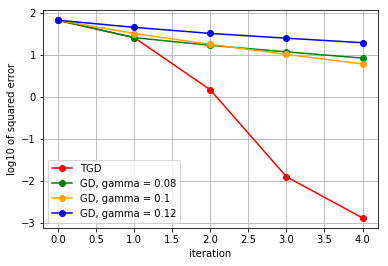

In [19]:
gd_model = GD(itr)
## trained TGD model
bs = 10000
solution = torch.tensor([[0.0, 0.0]]).repeat(bs,1) #解
with torch.no_grad():
    for i in range(1): 
        norm_list = []
        itr_list = []
        for i in range(itr):
            s_hat = model(i, bs)
            err = (torch.norm(solution - s_hat)**2).item()/bs
            norm_list.append(math.log10(err))
            itr_list.append(i)
        plt.plot(itr_list, norm_list, color="red", label="TGD",marker='o')
## normal GD
gamma = 0.08
norm_list = []
itr_list = []
for i in range(itr):
    s_hat = gd_model(i, bs, gamma)
    err = (torch.norm(solution - s_hat)**2).item()/bs
    norm_list.append(math.log10(err))
    itr_list.append(i)
plt.plot(itr_list, norm_list, color="green", label="GD, gamma = " + str(gamma),marker='o')
gamma = 0.10
norm_list = []
itr_list = []
for i in range(itr):
    s_hat = gd_model(i, bs, gamma)
    err = (torch.norm(solution - s_hat)**2).item()/bs
    norm_list.append(math.log10(err))
    itr_list.append(i)
plt.plot(itr_list, norm_list, color="orange", label="GD, gamma = " + str(gamma),marker='o')
gamma = 0.12
norm_list = []
itr_list = []
for i in range(itr):
    s_hat = gd_model(i, bs, gamma)
    err = (torch.norm(solution - s_hat)**2).item()/bs
    norm_list.append(math.log10(err))
    itr_list.append(i)
plt.plot(itr_list, norm_list, color="blue", label="GD, gamma = " + str(gamma),marker='o')
#plt.title("Error curves")
plt.grid()
plt.xlabel("iteration")
plt.ylabel("log10 of squared error")
plt.legend()
plt.show()

## $\beta_t$の学習結果をプロットしてみる

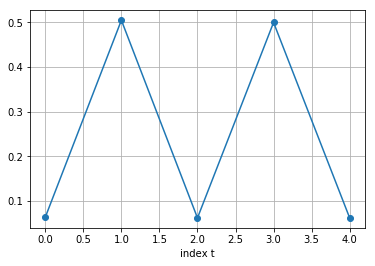

In [20]:
g = model.beta.to("cpu")
gval = g.detach().numpy()
gval = gval[0:itr]
ind = np.linspace(0,itr-1,itr)
plt.plot(ind, gval,marker='o')
plt.xlabel("index t")
plt.grid()
plt.show()